In [106]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Config

In [107]:
variant = 6

## Read data

In [108]:
def get_voltage(filename):
  match = re.search(r'[-+]?\d*\.\d+', filename)

  if match:
    return float(match.group())
  else:
    return None

In [109]:
data_dir = 'rawData'

x_time = None
matrix_time = None

voltages = {}

for filename in os.listdir(data_dir):
  file_path = os.path.join(data_dir, filename)

  if not os.path.isfile(file_path):
    continue

  voltage = get_voltage(filename)

  with open(file_path, 'r') as f:
    data = f.read().strip().splitlines()
    data_columns = [line.split(' ') for line in data]
    df = pd.DataFrame(data_columns)
    y = df[variant].to_numpy().astype(float)

    if x_time is None:
      x_time = df[0].to_numpy().astype(float)

    if matrix_time is None:
      matrix_time = y
    else:
      matrix_time = np.vstack((A, y))

    if not voltage in voltages:
      voltages[voltage] = y
    else:
      voltages[voltage] = np.concatenate((voltages[voltage], y))

x_time.shape, matrix_time.shape

((1024,), (56, 1024))

In [110]:
y_time = matrix_time.mean(axis=0)
y_time.shape

(1024,)

In [111]:
x_voltage = np.array(list(voltages.keys()))
x_voltage.shape

(11,)

In [112]:
y_voltage = np.array([voltages[voltage].mean() for voltage in voltages])
y_voltage.shape

(11,)

## Visualization

Text(0, 0.5, 'V')

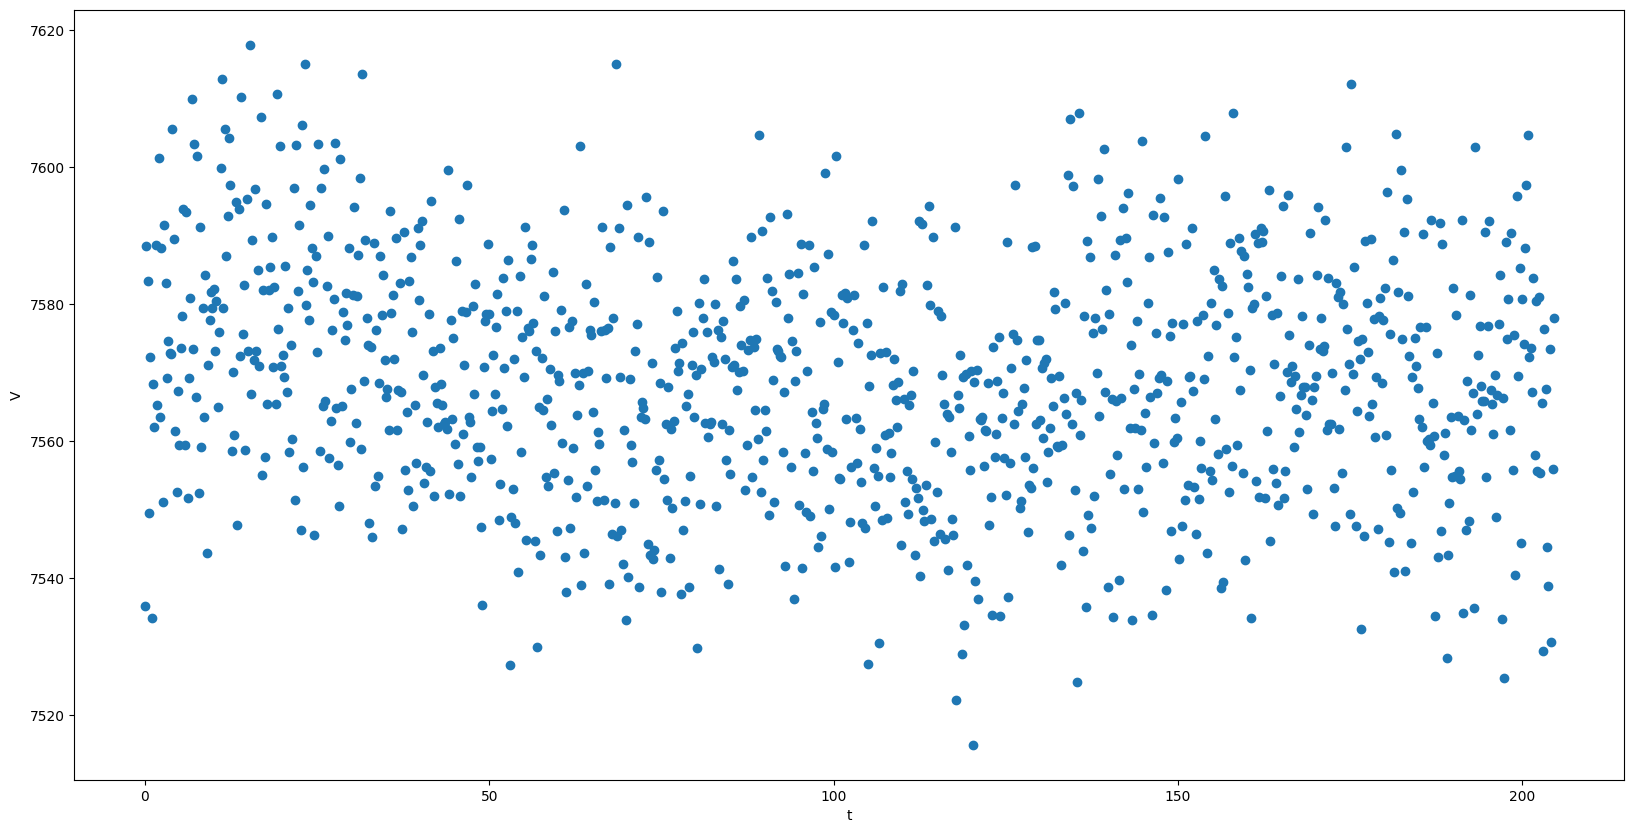

In [116]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time)
plt.xlabel('t')
plt.ylabel('V')

Text(0, 0.5, 'V')

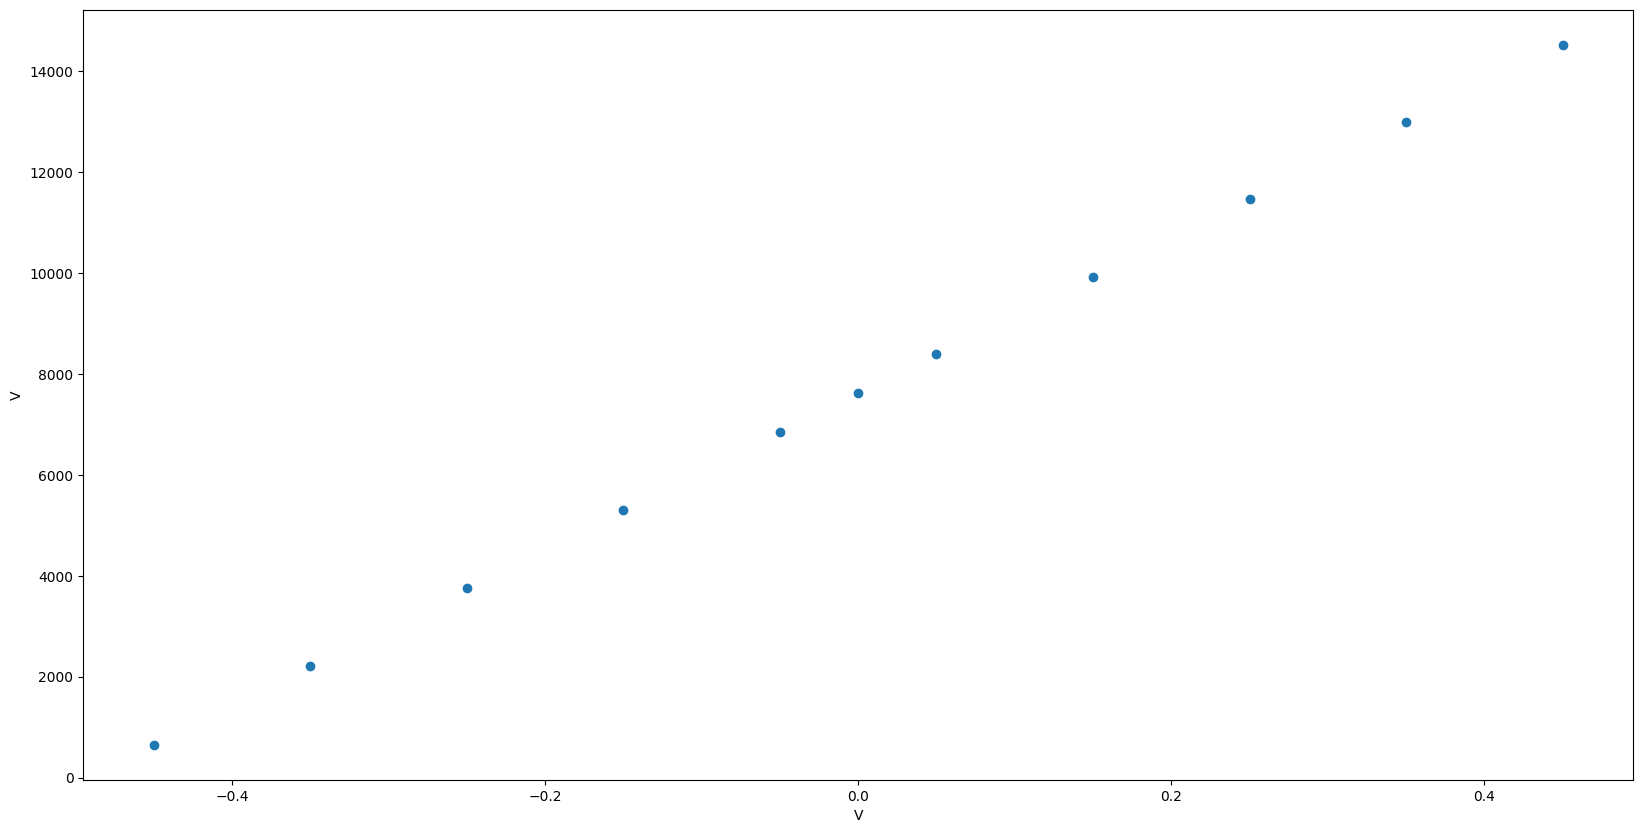

In [117]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage)
plt.xlabel('V')
plt.ylabel('V')